In [2]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import json
import re

In [ ]:
class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, augments=None, synonyms=None):
        super().__init__(root, annFile)
        self.augments = augments
        self.num_tokens = 1024
        self.synonyms = synonyms

    def bbox_to_tokens(self,bbox,img_width,img_height):
        """
        (x,y,w,h) -> token[y_min, x_min, y_max, x_max]
        """
        x,y,w,h = bbox
        x_min = int(round((x / img_width) * (self.num_tokens-1)))
        x_max = int(round(((x+w) / img_width) * (self.num_tokens-1)))
        y_min = int(round((y / img_height) * (self.num_tokens-1)))
        y_max = int(round(((y+h) / img_height) * (self.num_tokens-1)))

        bbox = [y_min,x_min,y_max,x_max]

        assert not any(v>self.num_tokens-1 or v<0 for v in bbox), f'incorrect calculation: {bbox}'

        return [f"<|loc{v:04d}|>" for v in bbox]

    def tokens_to_bbox(self,tokens,img_width,img_height):
        """
        token[y_min, x_min, y_max, x_max] -> (x,y,w,h)
        """
        y_min, x_min, y_max, x_max = [int(re.search(r"\d+", t).group()) for t in tokens]

        assert not any(v>self.num_tokens-1 or v<0 for v in [y_min, x_min, y_max, x_max]), f'incorrect tokens: {tokens}'

        x_min = (x_min / (self.num_tokens-1)) * img_width
        y_min = (y_min / (self.num_tokens-1)) * img_height
        x_max = (x_max / (self.num_tokens-1)) * img_width
        y_max = (y_max / (self.num_tokens-1)) * img_height

        bbox = [round(x_min,2), round(y_min,2), round(x_max-x_min, 2), round(y_max-y_min,2)]
        return bbox


    def __getitem__(self, index):
        image, target = super().__getitem__(index)
        image_np = np.array(image)

        bboxes = [obj['bbox'] for obj in target]
        category_ids = [obj['category_id'] for obj in target]

        augmented = self.augments(
            image=image_np,
            bboxes=bboxes,
            category_ids=category_ids
        )
        image = augmented['image']
        bboxes = augmented['bboxes']
        category_ids = augmented['category_ids']

        chosen_synonyms = {k:random.choice(v) for k,v in self.synonyms.items()}

        targets = dict()
        img_width, img_height = image.shape[1:]
        for i, bbox in enumerate(bboxes):
            tokens = self.bbox_to_tokens(bbox, img_width, img_height)
            category_label = chosen_synonyms[category_ids[i]]
            if targets.get(category_label,None) is None:
                targets[category_label] = list()
            targets[category_label].append(''.join(tokens))
        texts = []
        for label, tokens in targets.items():
            label_texts = '\n'.join([f"{token}; {label}" for token in tokens]).strip()
            texts.append(label_texts)

        text = '\n'.join(texts).strip() if len(texts) > 0 else 'no objects detected'

        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": f"<|detect|> {'; '.join(targets.keys()).strip()}"}
                ]
            },
            {
                "role": "assitant",
                "content": [
                    {"type": "text", "text": text}
                ]
            },
        ]


        return {
            'messages': conversation,
            'image': image
        }

In [4]:
base_path = Path('/data2/shreyas/datasets/coco/coco2017')
ds_info = {
    'train': {
        'dir': base_path / 'train2017',
        'annotation': base_path / 'annotations' / 'instances_train2017.json'
    },
    'val': {
        'dir': base_path / 'val2017',
        'annotation': base_path / 'annotations' / 'instances_val2017.json'
    }
}

In [5]:
with open(base_path/'categories.json') as f:
    category_synonyms = json.load(f)
    category_synonyms = {int(k):v for k,v in category_synonyms.items()}

In [ ]:
train_tfms = A.Compose([
    A.Resize(height=640,width=640),
    A.AtLeastOneBBoxRandomCrop(height=512, width=512, erosion_factor=0.2, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=15,
        p=0.5,
        border_mode=0
    ),
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(p=0.1),
    A.RGBShift(p=0.1),

    A.OneOf([
        A.GaussianBlur(p=1.0),
        A.MotionBlur(p=1.0),
        A.ISONoise(p=1.0)
    ], p=0.2),

    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5]),
    ToTensorV2(),

], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

In [73]:
train_ds = CocoDataset(
    root=ds_info['train']['dir'],
    annFile=ds_info['train']['annotation'],
    augments=train_tfms,
    synonyms=category_synonyms
)

loading annotations into memory...
Done (t=14.26s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


[{'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': '<|detect|> person; paddle'}]}, {'role': 'assitant', 'content': [{'type': 'text', 'text': '<|loc0082|><|loc0137|><|loc1023|><|loc0857|>; person\n<|loc0537|><|loc0212|><|loc1000|><|loc0440|>; person\n<|loc0608|><|loc0789|><|loc0913|><|loc0937|>; person\n<|loc0667|><|loc0742|><|loc0844|><|loc0828|>; person\n<|loc0105|><|loc0447|><|loc0891|><|loc0969|>; paddle'}]}]


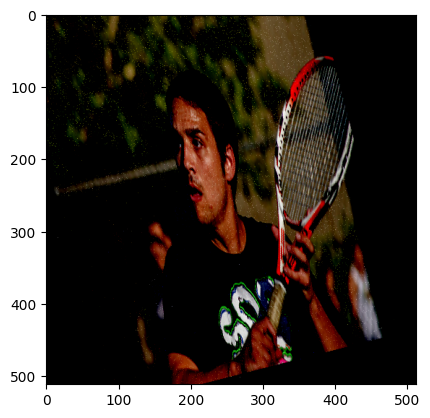

In [76]:
x=train_ds[1343]
fig,ax = plt.subplots(1,1)
ax.imshow(x[0].permute(1,2,0))
# bbox = x[1][0]['bbox2']
# patch = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor='red',lw=2)
# ax.add_patch(patch)
# bbox = x[1][0]['bbox']
# patch = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor='green',lw=2)
# ax.add_patch(patch)
# plt.show()
# print(x[1][0]['tokens'])
# print(x[1][0]['category_label'])
print(x[1])

In [52]:
from transformers import AutoProcessor, AutoTokenizer

In [49]:
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct")

In [54]:
new_tokens = ['<|detect|>',*[f'<|loc{v:04d}|>' for v in range(1024)]]
len(new_tokens)

1025

In [62]:
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-256M-Instruct", additional_special_tokens=new_tokens)